In [12]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn

from tqdm import tqdm

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class GasDataset(Dataset):
    def __init__(self, df, seq_len, type, year=None):
        self.seq_len = seq_len

        self.df = df.loc[df['type'] == type]
        if year is not None:
            self.df = self.df.loc[self.df['year'] == year]
    
    def __len__(self):
        return len(self.df) - self.seq_len - 1

    def __getitem__(self, idx):
        data = self.df.iloc[idx:idx + self.seq_len]
        date, x = data.date, torch.from_numpy(np.array(data[['supply']], dtype=np.float32))
        y = torch.from_numpy(np.array(self.df.iloc[idx + self.seq_len, -1], dtype=np.float32))

        return x, y

In [69]:
train_rate = 0.8
df = pd.read_csv("data/kor_gas_day.csv")
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, 7, 'A')
val_dataset = GasDataset(df_val, 7, 'A')

In [107]:
class TensorExtractor(nn.Module):
    def forward(self, x):
        tensor, _ = x
        return tensor
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer, conv_size=None):
        super(LSTM, self).__init__()
        lstm_layer = []
        if conv_size is not None:
            conv = nn.Conv1d(input_size, conv_size, kernel_size=4, stride=2, padding=0)
            lstm_layer.append(conv)
        lstm_layer.append(nn.LSTM(input_size, hidden_size, num_layer))
        lstm_layer.append(TensorExtractor())
        lstm_layer.append(nn.Linear(hidden_size, 1))
        self.lstm = nn.Sequential(*lstm_layer)
    
    def forward(self, x):
        return self.lstm(x)

In [97]:
def train(model, train_loader, val_data, optimizer, criterion, epoch):
    model.train()
    for i in (range(epoch)):
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.squeeze(-1).to(device)
            y = y.unsqueeze(-1).to(device)
            
            optimizer.zero_grad()
            output = model(x)
            
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i, epoch,
                100. * i / epoch, loss.item()))

    if val_data is not None:
        model.eval()
        loss = 0
        true_val = []
        predictions = []
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(val_data):
                
                x = x.view(1, -1).to(device)
                y = y.unsqueeze(-1).to(device)
                output = model(x).squeeze(-1)

                loss += criterion(output, y)
                true_val.append(float(y.cpu().numpy()))
                predictions.append(float(output.cpu().numpy()))
        

        print('\nTest set: Average loss: {:.4f}'.format(loss / len(val_data)))
        # print(true_val, predictions)
        plt.figure(figsize=(30,10))
        x = np.arange(len(true_val))
        plt.plot(x, true_val, label='true', c='blue')
        plt.plot(x, predictions, label='predictions', c='red')

        

In [103]:
seq_len = 7
train_rate = 0.2
df = pd.read_csv("data/kor_gas_day.csv")
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, seq_len, 'A')
val_dataset = GasDataset(df_val, seq_len, 'A')

In [108]:
hidden_szie = 128
num_layers = 50
learning_rate = 0.0001
epochs = 1000
batch_szie = 512

model = LSTM(seq_len, hidden_szie, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss().to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_szie)

Train Epoch: 1000 [0/1000 (0%)]	Loss: 336.490448
Train Epoch: 1000 [100/1000 (10%)]	Loss: 110.873772
Train Epoch: 1000 [200/1000 (20%)]	Loss: 79.612709
Train Epoch: 1000 [300/1000 (30%)]	Loss: 86.451439
Train Epoch: 1000 [400/1000 (40%)]	Loss: 76.968208
Train Epoch: 1000 [500/1000 (50%)]	Loss: 75.616974
Train Epoch: 1000 [600/1000 (60%)]	Loss: 72.281685
Train Epoch: 1000 [700/1000 (70%)]	Loss: 84.483292
Train Epoch: 1000 [800/1000 (80%)]	Loss: 59.171600
Train Epoch: 1000 [900/1000 (90%)]	Loss: 66.951279

Test set: Average loss: 92.3092


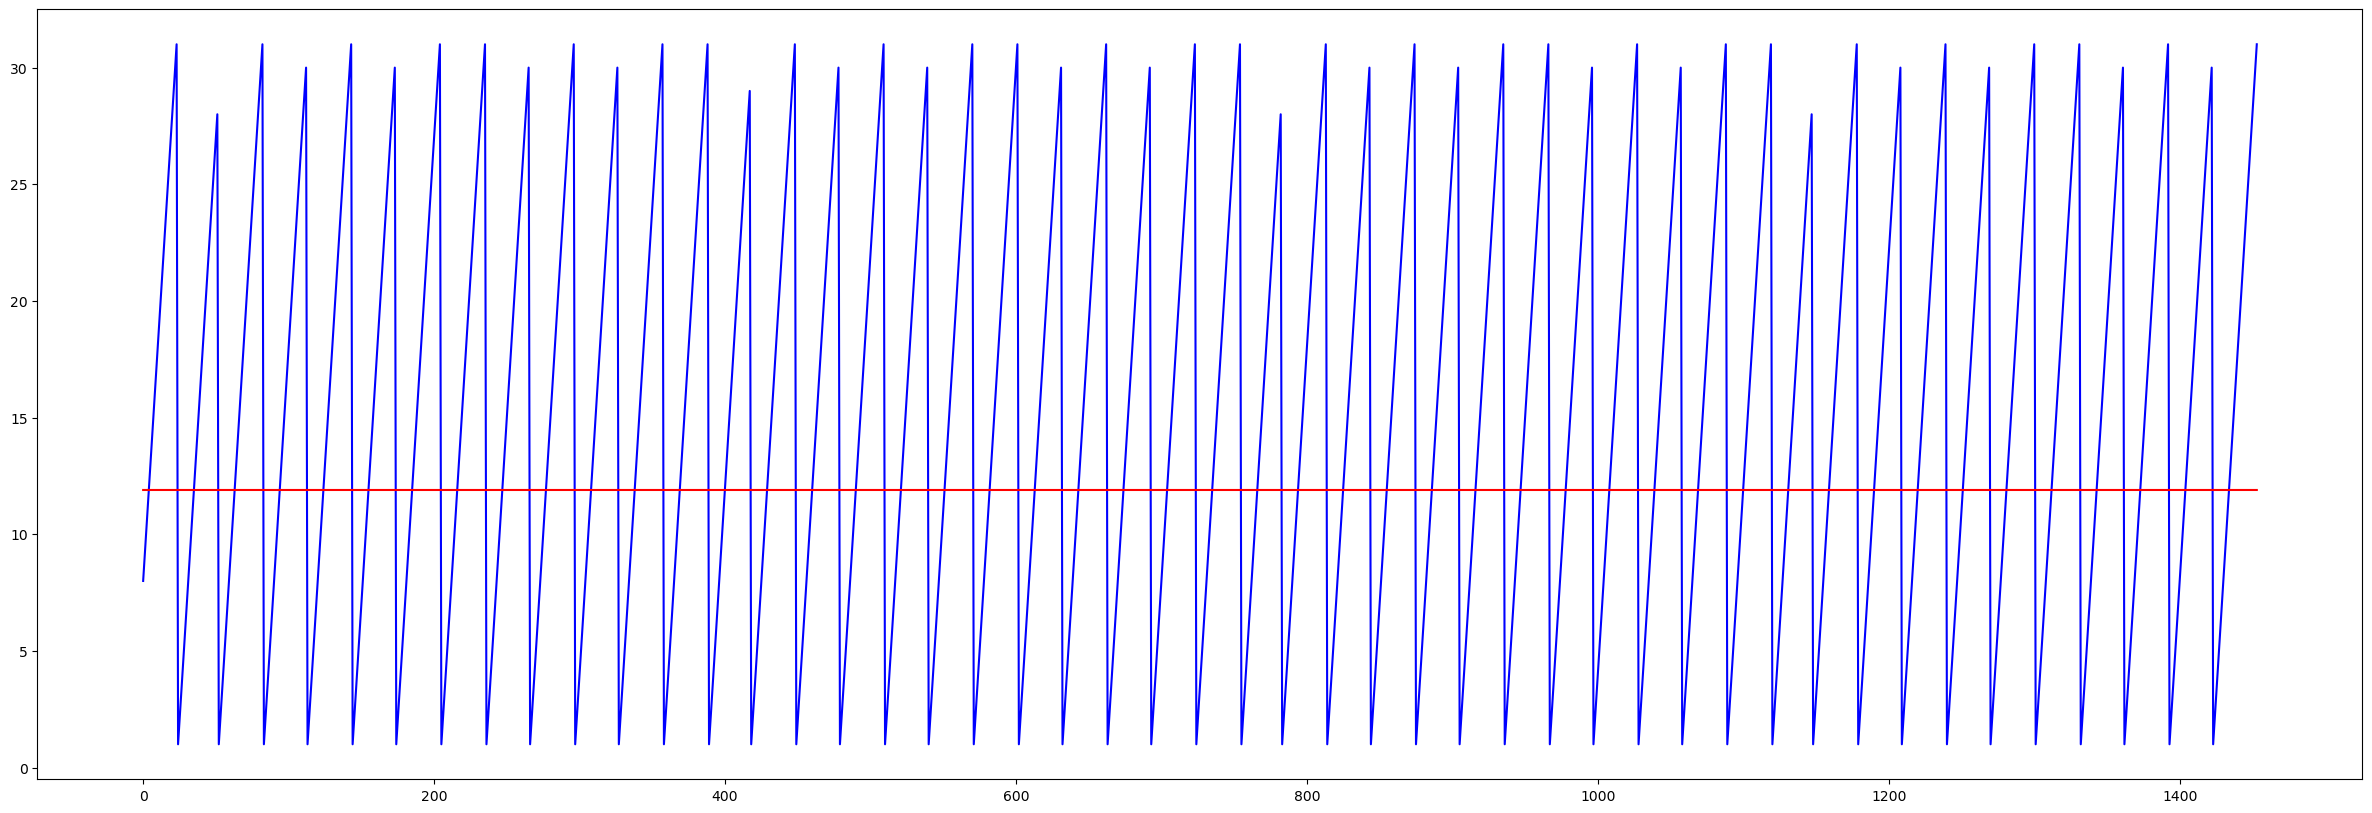

In [109]:
train(model, train_loader, val_dataset, optimizer, criterion, epochs)